In [1]:
import os,sys
get_ipython().run_line_magic('matplotlib','inline')
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'
import tensorflow as tf
import numpy as np
np.random.seed(1)
import matplotlib.pyplot as plt
%matplotlib inline
import datetime
import time
from collections import Counter
hdir = '/home/selab/Desktop/SELab_sy/NMSC/NMSC_2018/'
wdir = '/home/selab/Desktop/SELab_sy/NMSC/RNN/lstm_ch31/'

/home/selab/anaconda3/envs/tensorflow/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/selab/anaconda3/envs/tensorflow/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [2]:
def nearest(items,pivot):
    temp = min(items, key=lambda x: abs(x - pivot))
    return items.index(temp)

In [3]:
#kp to idx
kp2idx = {0.0:0, 0.3:1, 0.7:2, 1.0:3, 1.3:4, 1.7:5, 2.0:6, 2.3:7, 2.7:8, 3.0:9, 3.3:10, 3.7:11, 4.0:12, 4.3:13,
           4.7:14, 5.0:15, 5.3:16, 5.7:17, 6.0:18, 6.3:19, 6.7:20, 7.0:21, 7.3:22, 7.7:23, 8.0:24, 8.3:25, 8.7:26, 9.0:27}
#idx to kp
idx2kp = {0:0.0, 1:0.3, 2:0.7, 3:1.0, 4:1.3, 5:1.7, 6:2.0, 7:2.3, 8:2.7, 9:3.0, 10:3.3, 11:3.7, 12:4.0, 13:4.3,
           14:4.7, 15:5.0, 16:5.3, 17:5.7, 18:6.0, 19:6.3, 20:6.7, 21:7.0, 22:7.3, 23:7.7, 24:8.0, 25:8.3, 26:8.7, 27:9.0}    

max_idx_value = 27

In [4]:
#Kp index
data_kp = np.genfromtxt(hdir + 'KP_total.txt', names="year, month, day, hour, kp", dtype=(int, int, int, float,float))

In [5]:
#kp index daily number check
#total 6574 days, each 8 values
kp_time = []
for i in range(len(data_kp["kp"])):
    kp_time.append(datetime.datetime(data_kp["year"][i],data_kp["month"][i],data_kp["day"][i],int(data_kp["hour"][i]),30))

kp_date = []
for i in range(len(data_kp["kp"])):
    kp_date.append(datetime.date(data_kp["year"][i],data_kp["month"][i],data_kp["day"][i]))

tdel = kp_date[-1]-kp_date[0]


In [6]:
#max kp extraction
#kp2idx 
kp_max = []
kp_max_date = []
kp_timeHist = []
for i in range(tdel.days + 1):
    j=8*i
    maxidx = np.argmax(data_kp["kp"][j:j+8])
    kp_max.append(kp2idx[data_kp["kp"][j+maxidx]])
    kp_max_date.append(kp_date[j+maxidx])
    temp = kp_time[j+maxidx].time()
    kp_timeHist.append(temp.hour)

In [7]:
#CH
data_ch_reg = np.genfromtxt(hdir + 'CH_Regions_025scl2.dat', dtype=[('date', '<i8'), ('loc', '<U136')])

In [8]:
ch_time = []
ch_date = []
for i in range(len(data_ch_reg)):
    stamp = data_ch_reg["date"][i]
    ch_time.append(datetime.datetime(int(str(stamp)[0:4]),int(str(stamp)[4:6]),int(str(stamp)[6:8]),int(str(stamp)[8:10]),int(str(stamp)[10:12])))
    ch_date.append(datetime.date(int(str(stamp)[0:4]),int(str(stamp)[4:6]),int(str(stamp)[6:8])))

ch_date = list(set(ch_date))
ch_date.sort()

In [9]:
ch_reg = []

for i in range(len(ch_date)):
    nindx = nearest(ch_time,datetime.datetime.combine(ch_date[i],datetime.datetime.min.time()))
    ch_reg.append([data_ch_reg[nindx][0]]+[int(n) for n in data_ch_reg[nindx][1]])


In [10]:
#same observation data for kp and ch
#dat_tot에는 예측 기준날짜,지난 3일치 CH 데이터(136크기 어레이 *3), 예측할 kp값 이렇게 들어있음
dat_tot = []
for i in range(3,len(ch_date)):
    idx = kp_max_date.index(ch_date[i])
    dat_tot.append([ch_date[i],ch_reg[i-3][1:],ch_reg[i-2][1:],ch_reg[i-1][1:],kp_max[idx]])


In [11]:
## train, valid, test data set ##
div_tr = 6
div_va = 3
div_te = 3
div = int(len(dat_tot)/10*div_tr)

train = dat_tot[:int(div)]
val = dat_tot[int(div):int(div/div_tr*(div_tr+div_va))]
test = dat_tot[int(div/div_tr*(div_tr+div_va)):int(div/div_tr*(div_tr+div_va+div_te))]
print(len(train),len(val),len(test))

2578 1289 430


In [12]:
#CH의 경우 입력값 정규화 하지 않음. [1,0]이기 때문
x_train = np.array([xi[1:4] for xi in train])
y_train = np.array([yi[4] for yi in train]) #라벨 정규화는 필요없음
y_train = tf.keras.utils.to_categorical(y_train,28)

x_val =  np.array([xi[1:4] for xi in val])
y_val = np.array([yi[4] for yi in val])
y_val = tf.keras.utils.to_categorical(y_val,28)

In [13]:
x_te = np.array([xi[1:4] for xi in test])
y_te = np.array([yi[4] for yi in test])
y_te = tf.keras.utils.to_categorical(y_te,28)

In [14]:
# 3ch input 1 kp output
model = tf.keras.Sequential()
model.add(tf.keras.layers.LSTM(20, batch_input_shape = (1,3,136), stateful=False))
model.add(tf.keras.layers.Dense(28,activation='softmax'))

In [15]:
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (1, 20)                   12560     
_________________________________________________________________
dense (Dense)                (1, 28)                   588       
Total params: 13,148
Trainable params: 13,148
Non-trainable params: 0
_________________________________________________________________
None


In [16]:
model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy','mse'])

In [17]:
#Callback ft
class CustomHistory(tf.keras.callbacks.Callback):
    def init(self):
        self.train_loss = []
        self.val_loss = []
        self.train_acc = []
        self.val_acc = []        
        
    def on_epoch_end(self, batch, logs={}):
        self.train_loss.append(logs.get('loss'))
        self.val_loss.append(logs.get('val_loss'))
        self.train_acc.append(logs.get('acc'))
        self.val_acc.append(logs.get('val_acc'))
        

In [18]:
#Early stopper
def EarlyStop(history,patience):
    if len(history.val_loss)<=1 : 
        print('hislength')
        return patience
    
    nowloss = history.val_loss[-1]
    lastloss = history.val_loss[-2]
    if nowloss > lastloss :
        patience -= 1
    
    print('patience = '+str(patience))
    print('----------------------')
    return patience


In [19]:
num_epochs = 100
pat = 1
custom_hist = CustomHistory()
custom_hist.init()

In [20]:
#no early stopper
model.fit(x_train,y_train,epochs=num_epochs,batch_size=1, verbose=1, shuffle=False, callbacks=[custom_hist], validation_data=(x_val,y_val))

Train on 2578 samples, validate on 1289 samples
Epoch 1/100
2578/2578 [==============================] - 25s 10ms/step - loss: 2.9322 - acc: 0.0993 - mean_squared_error: 0.0334 - val_loss: 2.9422 - val_acc: 0.0745 - val_mean_squared_error: 0.0336
Epoch 2/100
2578/2578 [==============================] - 23s 9ms/step - loss: 2.8005 - acc: 0.1311 - mean_squared_error: 0.0330 - val_loss: 2.9344 - val_acc: 0.0745 - val_mean_squared_error: 0.0336
Epoch 3/100
2578/2578 [==============================] - 20s 8ms/step - loss: 2.7526 - acc: 0.1400 - mean_squared_error: 0.0329 - val_loss: 2.9550 - val_acc: 0.0768 - val_mean_squared_error: 0.0337
Epoch 4/100
2578/2578 [==============================] - 21s 8ms/step - loss: 2.7040 - acc: 0.1583 - mean_squared_error: 0.0326 - val_loss: 2.9877 - val_acc: 0.0838 - val_mean_squared_error: 0.0339
Epoch 5/100
2578/2578 [==============================] - 24s 9ms/step - loss: 2.6512 - acc: 0.1722 - mean_squared_error: 0.0324 - val_loss: 3.0109 - val_acc: 0

Epoch 42/100
2578/2578 [==============================] - 20s 8ms/step - loss: 0.8600 - acc: 0.7727 - mean_squared_error: 0.0126 - val_loss: 5.7235 - val_acc: 0.0667 - val_mean_squared_error: 0.0457
Epoch 43/100
2578/2578 [==============================] - 20s 8ms/step - loss: 0.8269 - acc: 0.7867 - mean_squared_error: 0.0121 - val_loss: 5.7969 - val_acc: 0.0698 - val_mean_squared_error: 0.0459
Epoch 44/100
2578/2578 [==============================] - 20s 8ms/step - loss: 0.7986 - acc: 0.7890 - mean_squared_error: 0.0117 - val_loss: 5.9273 - val_acc: 0.0698 - val_mean_squared_error: 0.0464
Epoch 45/100
2578/2578 [==============================] - 20s 8ms/step - loss: 0.7660 - acc: 0.8010 - mean_squared_error: 0.0112 - val_loss: 6.0078 - val_acc: 0.0659 - val_mean_squared_error: 0.0466
Epoch 46/100
2578/2578 [==============================] - 21s 8ms/step - loss: 0.7427 - acc: 0.8111 - mean_squared_error: 0.0109 - val_loss: 6.1148 - val_acc: 0.0659 - val_mean_squared_error: 0.0469
Epoch

2578/2578 [==============================] - 20s 8ms/step - loss: 0.1645 - acc: 0.9752 - mean_squared_error: 0.0020 - val_loss: 9.2578 - val_acc: 0.0706 - val_mean_squared_error: 0.0540
Epoch 84/100
2578/2578 [==============================] - 20s 8ms/step - loss: 0.1631 - acc: 0.9740 - mean_squared_error: 0.0021 - val_loss: 9.4000 - val_acc: 0.0714 - val_mean_squared_error: 0.0542
Epoch 85/100
2578/2578 [==============================] - 20s 8ms/step - loss: 0.1593 - acc: 0.9767 - mean_squared_error: 0.0020 - val_loss: 9.2995 - val_acc: 0.0698 - val_mean_squared_error: 0.0542
Epoch 86/100
2578/2578 [==============================] - 20s 8ms/step - loss: 0.1459 - acc: 0.9791 - mean_squared_error: 0.0018 - val_loss: 9.4308 - val_acc: 0.0698 - val_mean_squared_error: 0.0545
Epoch 87/100
2578/2578 [==============================] - 20s 8ms/step - loss: 0.1486 - acc: 0.9760 - mean_squared_error: 0.0019 - val_loss: 9.5390 - val_acc: 0.0698 - val_mean_squared_error: 0.0546
Epoch 88/100
2578/

In [21]:
model.save(wdir+'ch31.h5')

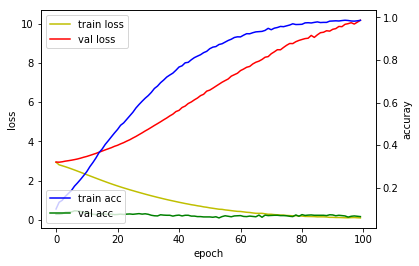

In [22]:
%matplotlib inline

loss_ax = plt.subplot()

acc_ax = loss_ax.twinx()

loss_ax.plot(custom_hist.train_loss, 'y', label='train loss')
loss_ax.plot(custom_hist.val_loss, 'r', label='val loss')

acc_ax.plot(custom_hist.train_acc, 'b', label='train acc')
acc_ax.plot(custom_hist.val_acc, 'g', label='val acc')

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuray')

loss_ax.legend(loc='upper left')
acc_ax.legend(loc='lower left')
plt.savefig(wdir+'ch31.png')
plt.show()
plt.close()

430/430 [==============================] - 1s 1ms/step
Evaluate
acc: 5.35%
Predict
acc : 5.35%
-0.006015980695870603
-1.135321921789393


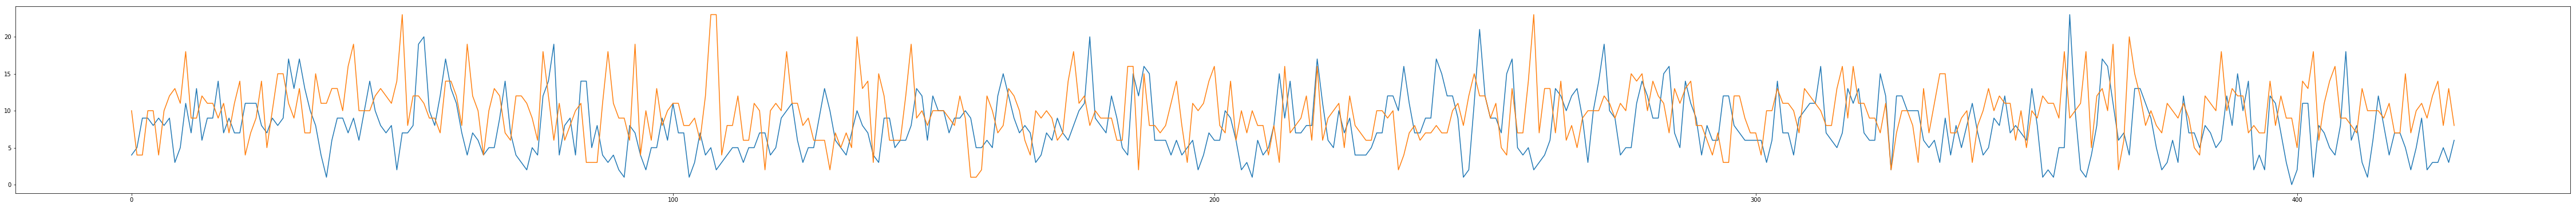

In [25]:
#test evaluate & predict
scores = model.evaluate(x_te,y_te,batch_size=1)
print("Evaluate")
print("%s: %.2f%%" %(model.metrics_names[1], scores[1]*100))

yhat = model.predict_classes(x_te,batch_size=1)
temp = [np.where(y == 1)[0][0] for y in y_te]
count = 0
for i in range(len(temp)):
    if temp[i] == yhat[i]: count +=1
print("Predict")
print("acc : %.2f%%" %(count/len(temp)*100))


plt.figure(figsize=(80,6))
plt.plot(temp,'-')
plt.plot(yhat,'-',alpha=1)
plt.savefig(wdir+'test_predict.png',dip=300)


#corr, SS
#제대로된 상관관계

y_te_la = np.asarray(temp)
sigref = np.std(y_te_la)
avgref = np.mean(y_te_la)

sigpre = np.std(yhat)
avgpre = np.mean(yhat)

corr = np.sum((y_te_la - avgref)*(yhat-avgpre))/sigref/sigpre/float(len(y_te_la))
print(corr)

#예측 효율 
mse_target = np.sum((y_te_la-yhat)**2)/len(y_te_la)
mse_ref = np.sum((y_te_la-avgref)**2)/len(yhat)
SS = 1-mse_target/mse_ref
print(SS)

2578/2578 [==============================] - 4s 2ms/step
acc: 96.16%
predict
acc : 96.16%
0.9627363120885675
0.9248762196925705


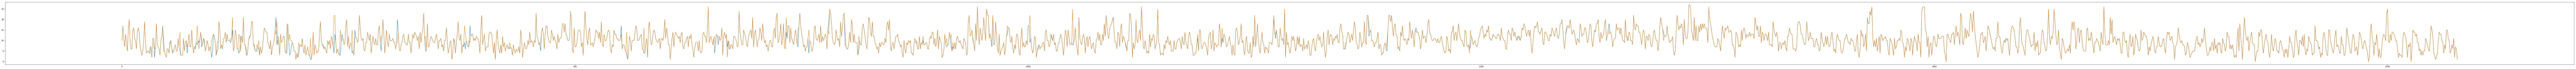

In [26]:
#train evaluate & predict 
scores = model.evaluate(x_train,y_train,batch_size=1)
print("%s: %.2f%%" %(model.metrics_names[1], scores[1]*100))

yhat_tr = model.predict_classes(x_train,batch_size=1)
temp2 = [np.where(y == 1)[0][0] for y in y_train]
count = 0
for i in range(len(temp2)):
    if temp2[i] == yhat_tr[i]: count +=1
print("predict")
print("acc : %.2f%%" %(count/len(temp2)*100))

plt.figure(figsize=(240,6))
plt.plot(temp2,'-')
plt.plot(yhat_tr,'-',alpha=1)
plt.savefig(wdir+'train_predict.png',dip=300)

#corr, SS
#제대로된 상관관계

y_te_la = np.asarray(temp2)
sigref = np.std(y_te_la)
avgref = np.mean(y_te_la)

sigpre = np.std(yhat_tr)
avgpre = np.mean(yhat_tr)

corr = np.sum((y_te_la - avgref)*(yhat_tr-avgpre))/sigref/sigpre/float(len(y_te_la))
print(corr)

#예측 효율 
mse_target = np.sum((y_te_la-yhat_tr)**2)/len(y_te_la)
mse_ref = np.sum((y_te_la-avgref)**2)/len(yhat_tr)
SS = 1-mse_target/mse_ref
print(SS)